In [87]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter, defaultdict
from itertools import product
from sklearn.metrics import confusion_matrix
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from bidict import bidict
from statistics import mean, mode
from multiprocessing import Process
from tqdm import tqdm
import glob
import random
import sys
import os
import re
import kenlm
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from pprint import pprint
import gc
from math import ceil

In [3]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [4]:
def to_python_lists(np_arr, lengths):
    return [row[:length] for row, length in zip(np_arr, lengths)]

def count_transitions(sequences):
    trans = [list(zip(seq[:-1], seq[1:])) for seq in sequences]
    trans = sum(trans, [])
    
    return Counter(trans)

def normalize_counter(counts):
    total = sum(counts.values(), 0)
    for key in counts:
        counts[key] /= total
    
    return counts

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def get_index(target, top_preds):    
    indices = np.where(top_preds == target)[0]
    if len(indices) == 0:
        return -1
    
    return indices[0]

# Helper Methods to Fetch Predictive Model Results

In [5]:
def fetch_ngram_results(res_dict=None, dataset="550"):
    """
    Fetch saved numpy matices of ngram prediction probabilities
    """
    if res_dict is None:
        res_dict = dict()
    
    models = ["bigram", "trigram", "4gram", "5gram"]
    ngram_preds_path = f"/data/rali7/Tmp/solimanz/data/ngram_preds/"
    for model in models:
        res_dict[model] = np.load(os.path.join(ngram_preds_path, model + dataset + '.npy'))

In [6]:
def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def get_neural_predictions(dataset, model='', info='predictions', use_skills=False):
    if use_skills:
        result_path = "/data/rali7/Tmp/solimanz/data/lstm_cnn_predictions"
    else:
        result_path = "/data/rali7/Tmp/solimanz/data/model_predictions"
    
    if use_skills:
        print(os.path.join(result_path, dataset, info))
        gen = next_batch(os.path.join(result_path, dataset, info))
        np_mats = glob.glob(os.path.join(result_path, dataset, info, '*.npy'))
        length_gen = next_batch(os.path.join(result_path, dataset, "seq_lengths"))
    else:
        print(os.path.join(result_path, dataset, model, 'fasttext', info))
        gen = next_batch(os.path.join(result_path, dataset, model, 'fasttext', info))
        np_mats = glob.glob(os.path.join(result_path, dataset, model, 'fasttext', info, '*.npy'))
        length_gen = next_batch(os.path.join(result_path, dataset, "fasttext", "seq_lengths"))
    
    predictions = []
    print(f"Fetching {model} for {dataset}...")
    for preds, lengths in tqdm(zip(gen, length_gen), total=len(np_mats), leave=False):
        if len(preds.shape) == 3:
            p = np.array([row[:seq_len,:][-1] for row, seq_len in zip(preds, lengths)])
        #elif len(preds.shape) == 3:
        #    p = preds[0]
        else:
            p = preds
            
        predictions.append((-p).argsort(axis=1))

    predictions = np.concatenate(predictions)

    #np.save(f"/data/rali7/Tmp/solimanz/data/model_predictions/{dataset}_{model}.npy", predictions)
    return predictions

In [7]:
def top_k_acc(preds, targets, k=1):
    """
    preds has shape (n_examples, n_labels)
    targets has shape (n_examples, 1)
    """

    #sorted_args = (-preds).argsort(axis=1)[:,:k]
    if len(preds.shape) == 1:
        acc = np.mean(preds == targets)
    else:
        sorted_args = preds[:,:k]
        tt = np.tile(targets, (k,1)).T
        acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def get_acc_df(preds, targets, dataset):
    
    ks = list(range(1,11))
    df_dict = {
    'top_k': [],
    'model': [],
    'accuracy': []
    }

    for name, ps in tqdm(preds.items(), leave=False):
        for k in ks:
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["accuracy"].append(round(top_k_acc(ps, targets, k), 5))
            
    return pd.DataFrame(df_dict)

In [8]:
results = dict()

# Load Datasets

In [9]:
def load_dataset(path):
    with open(os.path.join(path), "r") as f:
        data = json.load(f)
    return data

In [10]:
data = load_dataset("/data/rali7/Tmp/solimanz/data/datasets/top550/jobid/data.json")

In [11]:
targets = [s[1][-1] for s in data['test_data']]

In [12]:
len(targets)

24121

In [13]:
cnnlstm_preds = get_neural_predictions('top550', '', 'predictions', True)
lstm_preds = get_neural_predictions('top550', '', 'predictions', False)

  8%|▊         | 2/25 [00:00<00:01, 15.34it/s]

/data/rali7/Tmp/solimanz/data/lstm_cnn_predictions/top550/predictions
Fetching  for top550...


 16%|█▌        | 4/25 [00:00<00:00, 33.53it/s]

/data/rali7/Tmp/solimanz/data/model_predictions/top550/fasttext/predictions
Fetching  for top550...


In [14]:
results['cnn_lstm'] = cnnlstm_preds
results['lstm'] = lstm_preds

In [15]:
print(f"CNN-LSTM predictions shape: {results['cnn_lstm'].shape}")
print(f"LSTM predictions shape: {results['lstm'].shape}")

CNN-LSTM predictions shape: (24121, 551)
LSTM predictions shape: (24121, 551)


# Predict Most Probable Baseline (MoPro)

In [16]:
# MoPro
class MostProbable():
    
    def train(self, train, count_last=True):
        if count_last:
            counts = Counter([d[1][-1] for d in train])
            self.prediction = counts.most_common(1)[0][0]
        else:
            counts = Counter(sum([d[1] for d in train], []))
            self.prediction = counts.most_common(1)[0][0]
    
    def predict(self, test):        
        return np.array([self.prediction] * len(test))

In [17]:
most_prb_550 = MostProbable()
most_prb_550.train(data['train_data'], True)
results['MoPro'] = most_prb_550.predict(data['test_data'])

# Predict Last Baseline (PreLA)

In [18]:
#PreLa
def predict_last(test):
    return np.array([d[1][-2] for d in test])

In [19]:
results['PreLa'] = predict_last(data['test_data'])

In [20]:
print(f"MoPro predictions shape: {results['MoPro'].shape}")
print(f"PreLa predictions shape: {results['PreLa'].shape}")

MoPro predictions shape: (24121,)
PreLa predictions shape: (24121,)


# Fetch N-gram Models

In [21]:
fetch_ngram_results(results)

In [22]:
for model in ["bigram", "trigram", "4gram", "5gram"]:
    print(f"Shape of {model}: {results['bigram'].shape}")

Shape of bigram: (24121, 551)
Shape of trigram: (24121, 551)
Shape of 4gram: (24121, 551)
Shape of 5gram: (24121, 551)


In [23]:
results.keys()

dict_keys(['cnn_lstm', 'lstm', 'MoPro', 'PreLa', 'bigram', 'trigram', '4gram', '5gram'])

# Fetch Naive Bayes Models

In [24]:
def fetch_nb_results(model='multi_nb_550', res_dict=None):
    if res_dict is None:
        res_dict = dict()
    ngram_preds_path = "/data/rali7/Tmp/solimanz/data/nb_preds/"
    
    preds = np.load(os.path.join(ngram_preds_path, model + '.npy'))
    res_dict["multi_nb"] = (-preds).argsort(axis=1)#[:, :10]

In [25]:
fetch_nb_results('multi_nb_550', results)

In [26]:
print(f"Multinomial Naive Bayes preds shape: {results['multi_nb'].shape}")

Multinomial Naive Bayes preds shape: (24121, 550)


In [27]:
accs = get_acc_df(results, targets, '550_titles')

In [72]:
#models = accs.model.unique()
models = ['bigram', 'trigram', 'lstm', 'cnn_lstm', 'multi_nb', 'MoPro', 'PreLa']

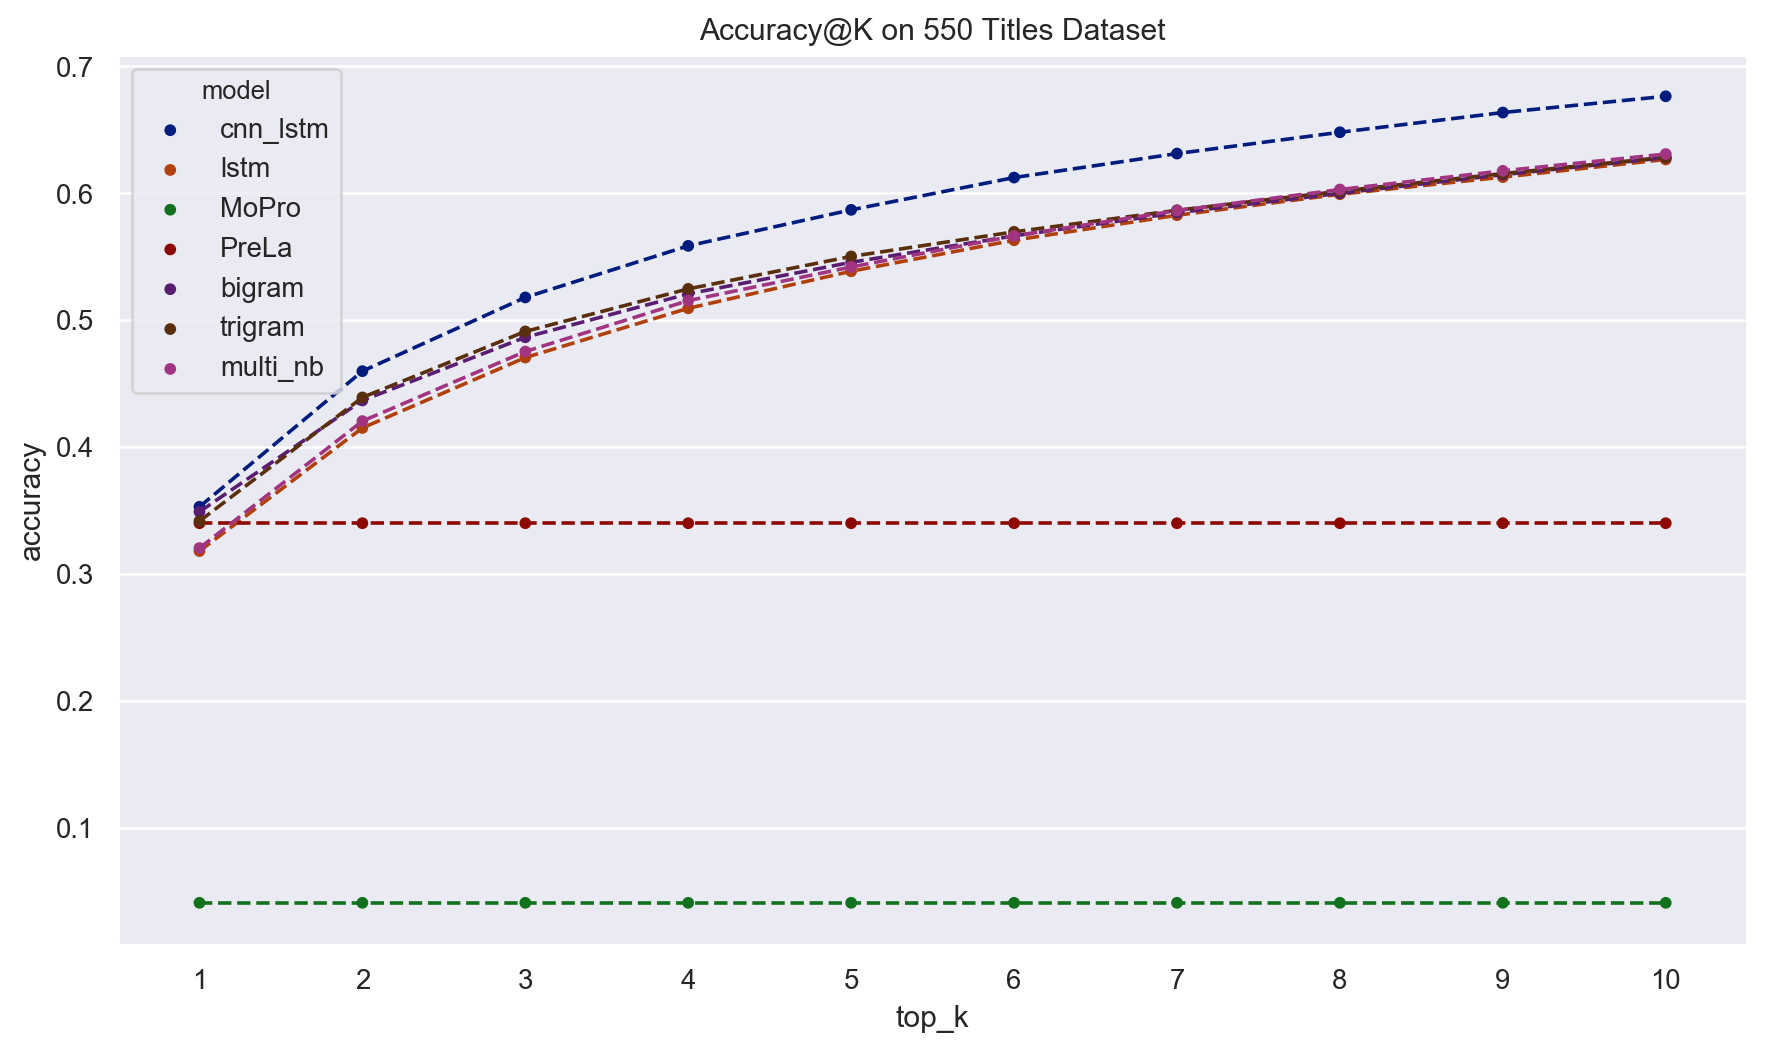

In [74]:
plt.rcParams['figure.dpi'] = 180
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(x='top_k', y='accuracy', hue='model', linestyles='--', 
              data=accs[accs.model.isin(models)], ax=ax)
ax.set_title('Accuracy@K on 550 Titles Dataset')
plt.tight_layout()

In [75]:
fig.savefig('/data/rali7/Tmp/solimanz/LBJ/viz/all_res.pdf', dpi=180, facecolor=fig.get_facecolor())

## Accuracy by Length

In [52]:
def groupby_length(seq_lengths):
    d = dict()
    lengths = seq_lengths - 1
    for i in range(2, lengths.max()+1):
        d[i] = np.where(lengths == i)[0]
    return d
        
def accuracy_by_length(preds_dict, targets, seq_lengths, k=1):
    """
    preds: predictions of the model (n_examples, max_length, n_labels)
    targets: numpy array, prediction targets with shape (n_examples, max_lenth, n_labels)
    groups: dictionary grouping the indices of the input sequences by length
    """
    groups = groupby_length(seq_lengths)
    accs = defaultdict(list)
    for length, indices in groups.items():
        if len(indices) > 0:
            for model, preds in preds_dict.items():
                p = preds[indices]
                t = targets[indices]
                accs['accuracy'].append(top_k_acc(p, t, k))
                accs['length'].append(length)
                accs['model'].append(model)
                
    return pd.DataFrame(accs)

In [76]:
seq_lengths = np.array([len(d[1]) for d in data['test_data']])
train_lengths = Counter([len(d[1]) - 1 for d in data['train_data'] if len(d[1]) <= 10])
lengths, counts = zip(*train_lengths.most_common())
lengths = [l-2 for l in lengths]

In [77]:
df = accuracy_by_length(results, np.array(targets), seq_lengths)

In [78]:
models = ['bigram', 'cnn_lstm', 'multi_nb', 'PreLa']
dat = df[df.model.isin(models)]
dat = dat[dat.length <= 9]

Text(0.5,1,'550 Titles Dataset')

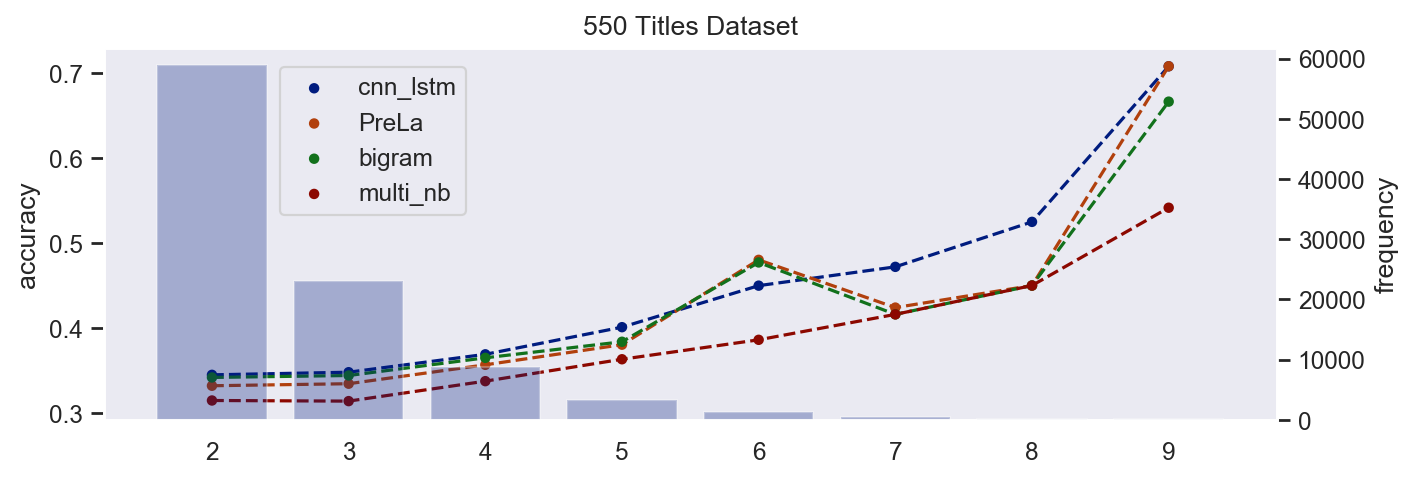

In [79]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.8
fig, ax = plt.subplots(figsize=(9,3), ncols=1, nrows=1)

sns.pointplot(x='length', y='accuracy', hue='model', alpha=0.3, linestyles='--', 
              data=dat, ax=ax)

axt = ax.twinx()
axt.bar(lengths, counts, alpha=0.3)
axt.set_ylabel('frequency')
ax.set_xlabel('')

ax.legend(loc=(0.15, 0.55))
ax.grid(False)
axt.grid(False)
plt.tight_layout()
ax.set_title('550 Titles Dataset')

In [80]:
fig.savefig('/data/rali7/Tmp/solimanz/LBJ/viz/acc_len.pdf', dpi=180, facecolor=fig.get_facecolor())

## Frequency of change Through time

In [99]:
seqs_trans = [get_ngrams(2, d[1]) for d in data['train_data']]

In [100]:
def compute_change_freq(seqs_trans, max_len):
    change_freq = {}
    totals = {}

    for i in range(max_len):
        changed = 0.0
        total = 0.0
        for seq in seqs_trans:
            if i < len(seq):
                total += 1
                trans = seq[i]
                if trans[0] != trans[1]:
                    changed += 1
        
        if total > 0:
            change_freq[i+1] = changed/total
        else:
            change_freq[i+1] = 0
            
        totals[i+1] = total
        
    return change_freq, totals

In [ ]:
change_freq, tots = compute_change_freq(seqs_trans, data['maximum_seq_len'])

In [102]:
x1 = []
y1 = []

for k, v in change_freq.items():
    x1.append(k)
    y1.append(v)

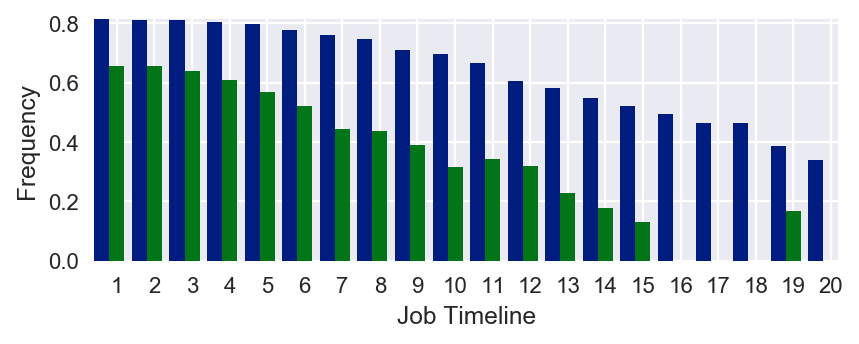

In [103]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['figure.figsize'] = (6,2)
plt.rcParams['lines.linewidth'] = 1
fig = plt.gcf()
ax = plt.subplot(111)
w = 0.4
ax.bar(np.array(x2[:20]) - w, y2[:20], width=w, align='center')
ax.bar(np.array(x1[:20]), y1[:20], width=w, align='center')
#plt.title("Frequency of Job Title Change Through Time")
plt.ylabel("Frequency")
plt.xlabel("Job Timeline")
ax.autoscale(tight=True)
ticks = ax.set_xticks(np.arange(1,21))

In [104]:
fig.savefig('../../../Dropbox/thesis/thesis/images/freq_change.png', dpi=180, facecolor=fig.get_facecolor())

## Prediction Targets Frequency

In [81]:
targets_length = dict()
for i in range(2, 10):
    selection = [seq[1] for seq in data['test_data'] if len(seq[1]) - 1 == i]
    targets_length[i] = [seq[-1] for seq in selection]

In [82]:
# From Training Data Set
train_targets = normalize_counter(Counter([d[1][-1] for d in data['train_data']]))

In [83]:
sorted_550 = train_targets.most_common(len(train_targets))

In [84]:
mapping = bidict({t[0]: i for i, t in enumerate(sorted_550)})

In [86]:
x1 , y1 = zip(*sorted_550)
x1 = [mapping[i] for i in x1]

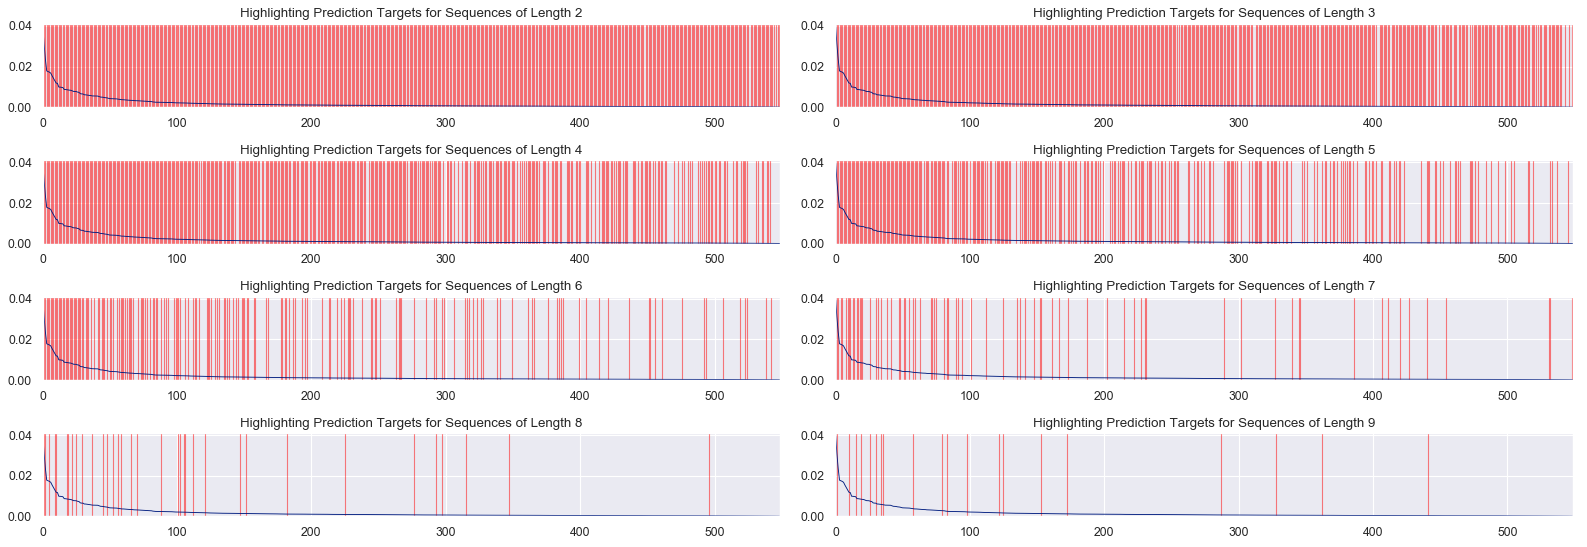

In [104]:
#plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.dpi'] = 80

lengths = [2,3,4,5,6,7,8,9]
f, axarr = plt.subplots(ceil(len(lengths)/2), 2 , figsize=(20,7), sharex=False)
row = 0
for l in lengths:
    col = l%2
    axarr[row][col].plot(x1, y1)
    for target in set(targets_length[l]):
        if target in mapping:
            axarr[row][col].axvspan(mapping[target],mapping[target], color='red', alpha=0.5)
    axarr[row][col].set_title(f'Highlighting Prediction Targets for Sequences of Length {l}')
    axarr[row][col].autoscale(tight=True)
    row += l%2
    
plt.tight_layout()

In [105]:
f.savefig('/data/rali7/Tmp/solimanz/LBJ/viz/targets_dist_550.pdf', dpi=180, facecolor=fig.get_facecolor())

In [118]:
df_dict = defaultdict(list)

for model, topK_preds in results.items():
    for i, predictions in enumerate(topK_preds):
        if model == "PreLa" or model =="MoPro":
            df_dict[f"{model}_pred"].append(predictions)
            df_dict[f"{model}_correct_at"].append(0 if targets[i] == predictions else -1)
        else:
            df_dict[f"{model}_pred"].append(predictions[0])
            df_dict[f"{model}_correct_at"].append(get_index(targets[i], predictions))

df_dict["target"] = list(targets)
preds = pd.DataFrame(df_dict)

In [106]:
def get_word_level_acc(preds_sigmoid, target_sets, k=5, cutoff=0.5, method='strict'):    
    matches = np.where(preds_sigmoid >= cutoff)
    predictions = []        
    for i in range(len(target_sets)):
        predictions.append(set())
        
    if method == 'loose':     
        for i, j in zip(*matches):
            predictions[i].add(j)        
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(preds_sigmoid[i]))
                
        precision = recall = [int(bool(len(targets.intersection(preds))))
                              for targets, preds in zip(target_sets, predictions)
                             if len(targets) > 0 and len(preds) > 0]
    elif method == 'strict':        
        for i, j in zip(*matches):
            predictions[i].add(j)   
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(predictions[i]))
                
        recall = [len(targets.intersection(preds))/len(targets) 
                     for targets, preds in zip(target_sets, predictions) 
                  if len(targets) > 0 and len(preds) > 0]
        precision = [len(targets.intersection(preds))/len(preds) 
                  for targets, preds in zip(target_sets, predictions) 
                     if len(targets) > 0 and len(preds) > 0]
    elif method == 'top-k':
        p = (-preds_sigmoid).argsort(axis=1)[:,:k]
        predictions = [set(i) for i in p]
        recall = [len(targets.intersection(preds))/len(targets) 
                     for targets, preds in zip(target_sets, predictions)
                 if len(targets) > 0 and len(preds) > 0]
        precision = [len(targets.intersection(preds))/len(preds) 
                  for targets, preds in zip(target_sets, predictions)
                    if len(targets) > 0 and len(preds) > 0]
        #precision = [int(bool(len(targets.intersection(preds)))) 
        #             for targets, preds in zip(target_sets, predictions)]
    elif method == 'equal':      
        for i, j in zip(*matches):
            predictions[i].add(j)
        for i, preds in enumerate(predictions):
            if not preds:
                preds.add(np.argmax(predictions[i]))
                
        recall = precision = [int(targets == preds) 
                              for targets, preds in zip(target_sets, predictions) 
                             if len(targets) > 0 and len(preds) > 0]
    else:
        print("Please choose a metric method between: loose, strict, equal, top-k")
        
        
    return mean(precision), mean(recall)

In [107]:
def map_titles_to_labels(title_id, label_id):    
    tokenizer = RegexpTokenizer(r'\s+|\W', gaps=True)
    title_labels = dict()    
    for title in title_id.keys():
        toks = tokenizer.tokenize(title)
        labels = [label_id[t] for t in toks if t in label_id]
        title_labels[title_id[title]] = labels
    return title_labels

def word_lvl(predictions, targets, label_id, title_id, method='strict'):
    # Transfrom prediction labels to multilabel
    title_labels = map_titles_to_labels(title_id, label_id)
    if method == 'top-k':
        preds = [[set(title_labels[p]) for p in top] for top in predictions]
        preds = [set.union(*p) for p in preds]
    else:
        preds = [set(title_labels[p]) for p in predictions]
    targs = [set(title_labels[t]) for t in targets]
    
    if method == 'loose':
        precision = recall = [int(bool(len(ts.intersection(ps))))
                              for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'strict':           
        recall = [len(ts.intersection(ps))/len(ts) 
                     for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
        precision = [len(ts.intersection(ps))/len(ps) 
                  for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'equal':  
        recall = precision = [int(ts == ps) 
                              for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    elif method == 'top-k':
        recall = [len(ts.intersection(ps))/len(ts) 
                     for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
        precision = [len(ts.intersection(ps))/len(ps) 
                  for ts, ps in zip(targs, preds) if len(ts) > 0 and len(ps) > 0]
    else:
        print("Please choose a metric method between: loose, strict, equal, top-k")
    
    return mean(precision), mean(recall)

In [109]:
def metrics_multilabel(preds, targets, methods, cutoff, k=5):
    for method in methods:
        p, r = get_word_level_acc(preds, targets, k=k, cutoff=cutoff, method=method)
        print(f"**Metric {method}\nPrecision:\t{p*100:.2f}%\nRecall:\t{r*100:.2f}%\n")
    
def metrics_job_level_models(dat, models, label_id, title_id, topk=False, k=5):
    if topk:
        metrics = ["top-k"]
    else:
        metrics = ["loose", "strict", "equal"]
    
    for method, model in product(metrics, models):
        if topk:
            pass
        else:
            p, r = word_lvl(dat[f"{model}_pred"].values, 
                            dat["target"].values, 
                            label_id, title_id, method)
        
        print(f"**Model {model} with metric {method}\nPrecision:\t\t{p*100:.2f}\nRecall:\t\t{r*100:.2f}\n\n")

In [120]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/multilabel/top550/"

# Load data dicts
with open(os.path.join(path550, "data2.json"), "r") as f:
    ml550 = json.load(f)

In [121]:
models = ['PreLa', 'bigram', 'trigram', 'multi_nb', 'cnn_lstm', 'lstm']
methods = ["strict", "loose", "equal"]
metrics_job_level_models(preds, models, ml550["label_id"], ml550["title_to_id"])

**Model PreLa with metric loose
Precision:		51.26
Recall:		51.26


**Model bigram with metric loose
Precision:		51.54
Recall:		51.54


**Model trigram with metric loose
Precision:		50.08
Recall:		50.08


**Model multi_nb with metric loose
Precision:		48.28
Recall:		48.28


**Model cnn_lstm with metric loose
Precision:		51.93
Recall:		51.93


**Model lstm with metric loose
Precision:		48.27
Recall:		48.27


**Model PreLa with metric strict
Precision:		44.30
Recall:		44.02


**Model bigram with metric strict
Precision:		45.14
Recall:		44.32


**Model trigram with metric strict
Precision:		43.93
Recall:		43.23


**Model multi_nb with metric strict
Precision:		42.25
Recall:		41.00


**Model cnn_lstm with metric strict
Precision:		45.66
Recall:		44.68


**Model lstm with metric strict
Precision:		41.86
Recall:		41.17


**Model PreLa with metric equal
Precision:		34.05
Recall:		34.05


**Model bigram with metric equal
Precision:		34.97
Recall:		34.97


**Model trigram with metric equal
Preci

# Error Analysis

In [122]:
def error_cause(data, n, preds, models):
    
    seqs_trans = []
    for d in data['train_data']:
        seqs_trans += get_ngrams(n, d[1])
    
    seqs_trans = Counter(seqs_trans)
    most_common = dict()
    for trans, freq in seqs_trans.most_common(len(seqs_trans)):
        if trans[:-1] not in most_common:
            most_common[trans[:-1]] = trans[-1]   
    
    dat = np.array([v[1] for v in data['test_data']])
    
    for model in models:
        wrong = preds[preds[model] != preds['target']]  
        mc_preds = []
        for v in dat[wrong.index]:
            if tuple(v[len(v)-n:-1]) in most_common:
                mc_preds.append(most_common[tuple(v[len(v)-n:-1])])
            else:
                mc_preds.append(v[-2])
        p = len(wrong[np.equal(wrong[model].values, mc_preds)])/len(wrong)
        print(f"{p*100:.2f}% of {model}'s prediction mistakes are the most commonly seen transition")

In [123]:
def freq_based_acc(sorted_data, pred_df, models, cutoff=0.1):
    
    #freqs = [t[1] for t in sorted_data]
    #most = [i for i in list(range(0,cutoff))]
    #least = [i for i in list(range(cutoff, len(freqs)))]
    n = ceil(len(sorted_data) * cutoff)
    most = [s[0] for s in sorted_data[:n]]
    least = [s[0] for s in sorted_data[n:]]
    most_freq = pred_df[pred_df['target'].isin(most)]
    least_freq = pred_df[pred_df['target'].isin(least)]
    
    most_freq_acc = dict()
    least_freq_acc = dict()
    for model in models:
        most_freq_acc[model] = len(most_freq[most_freq.target == most_freq[model]])/len(most_freq) * 100
        least_freq_acc[model] = len(least_freq[least_freq.target == least_freq[model]])/len(least_freq) * 100
    
    pprint(most_freq_acc)
    pprint(least_freq_acc)

In [129]:
models = ['PreLa_pred', 'bigram_pred', 'trigram_pred', 'multi_nb_pred', 'cnn_lstm_pred', 'lstm_pred']
error_cause(data, 2, preds, models)
freq_based_acc(sorted_550, preds, models, cutoff=0.1)

89.65% of PreLa_pred's prediction mistakes are the most commonly seen transition
95.26% of bigram_pred's prediction mistakes are the most commonly seen transition
67.74% of trigram_pred's prediction mistakes are the most commonly seen transition
49.68% of multi_nb_pred's prediction mistakes are the most commonly seen transition
64.89% of cnn_lstm_pred's prediction mistakes are the most commonly seen transition
51.25% of lstm_pred's prediction mistakes are the most commonly seen transition
{'PreLa_pred': 35.34182142567513,
 'bigram_pred': 37.961235909496395,
 'cnn_lstm_pred': 40.97802286919146,
 'lstm_pred': 36.81777633606358,
 'multi_nb_pred': 40.41845754602222,
 'trigram_pred': 38.05044197550888}
{'PreLa_pred': 32.6151497158368,
 'bigram_pred': 31.724488930358806,
 'cnn_lstm_pred': 29.366358469759945,
 'lstm_pred': 26.584103825600135,
 'multi_nb_pred': 23.30138264483841,
 'trigram_pred': 30.12129951649843}


# Mean Percentile Ranking

In [4]:
ml_path = "/data/rali7/Tmp/solimanz/data/multilabel_model_predictions/"
cnn_ml_path = "/data/rali7/Tmp/solimanz/data/multilabel_lstm_cnn_predictions/"

In [10]:
multi_label_cnn = dict()
datasets = ['reduced7k', 'top550']
for ds in datasets:
    mats = []
    gen = next_batch(os.path.join(cnn_ml_path, ds, 'predictions'))
    for preds in gen:
        mats.append(preds)
    multi_label_cnn[ds] = np.concatenate(mats)

In [11]:
print(multi_label_cnn['top550'].shape)
print(multi_label_cnn['reduced7k'].shape)

(24121, 326)
(167581, 1856)
